# Training Deep Neural Networks (Tiếp)
Trong buổi này, chúng ta tiếp tục làm quen với một số kỹ thuật huấn luyện mạng nơ-ron

In [ ]:
!nvidia-smi
# from google.colab import drive
# drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Wed Oct  6 06:21:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1. Cài đặt BatchNorm

In [ ]:
def compare_bn(bn1, bn2):
    err = False
    if not torch.allclose(bn1.running_mean, bn2.running_mean):
        print('Diff in running_mean: {} vs {}'.format(
            bn1.running_mean, bn2.running_mean))
        err = True

    if not torch.allclose(bn1.running_var, bn2.running_var):
        print('Diff in running_var: {} vs {}'.format(
            bn1.running_var, bn2.running_var))
        err = True

    if bn1.affine and bn2.affine:
        if not torch.allclose(bn1.weight, bn2.weight):
            print('Diff in weight: {} vs {}'.format(
                bn1.weight, bn2.weight))
            err = True

        if not torch.allclose(bn1.bias, bn2.bias):
            print('Diff in bias: {} vs {}'.format(
                bn1.bias, bn2.bias))
            err = True

    if not err:
        print('All parameters are equal!')


class MyBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1,
                 affine=True, track_running_stats=True):
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)

    def forward(self, input):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3])
            # use biased var in train
            var = input.var([0, 2, 3], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        # Chuẩn hoá input
        ######################
        ### YOUR CODE HERE ###
        ######################
        # input = (input - mean(input))/sqrt(var(input))
        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
        if self.affine:
            # Biến đổi input sau khi chuẩn hoá
            ######################
            ### YOUR CODE HERE ###
            ######################
            input = input * self.weight[None, :, None, None] + self.bias[None, :, None, None]
        return input


# Init BatchNorm layers
my_bn = MyBatchNorm2d(3, affine=True)
bn = nn.BatchNorm2d(3, affine=True)

compare_bn(my_bn, bn)  # weight and bias should be different
# Load weight and bias
my_bn.load_state_dict(bn.state_dict())
compare_bn(my_bn, bn)

# Run train
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)
    print('Max diff: ', (out1 - out2).abs().max())

# Run eval
my_bn.eval()
bn.eval()
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)

All parameters are equal!
All parameters are equal!
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(2.3842e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are

### 2. Cài đặt chiến lược thay đổi tốc độ học: Warm-up + Cosine Annealing LR

In [ ]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),                            
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [ ]:
trainset, testset = load_data('./data')
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
)

epochs = 50
warm_epoch = 5
init_lr = 1e-1
last_lr = 1e-5
T_max = epochs
T_cur = 0
lr_list = [0]

net = Net()
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=init_lr, momentum=0.9)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    T_cur += 1
    
    # warm-up and cosine annealing lr

    ######################
    ### YOUR CODE HERE ###
    ######################
    if epoch <= warm_epoch:
      optimizer.param_groups[0]['lr'] = (1.0 + epoch)/warm_epoch * init_lr
    else:
      optimizer.param_groups[0]['lr'] = last_lr + (init_lr - last_lr)*(1 + np.cos(T_cur*np.pi/T_max))/2
   
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i + 1 == len(trainloader):
            print("[Epoch %d] loss: %.3f" % (epoch, running_loss / epoch_steps))
            running_loss = 0.0
            
    lr_list.append(optimizer.param_groups[0]['lr'])

print("Finished Training")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 1] loss: 2.297
[Epoch 2] loss: 2.156
[Epoch 3] loss: 2.091
[Epoch 4] loss: 2.290
[Epoch 5] loss: 2.357
[Epoch 6] loss: 2.361
[Epoch 7] loss: 2.361
[Epoch 8] loss: 2.361
[Epoch 9] loss: 2.361
[Epoch 10] loss: 2.361
[Epoch 11] loss: 2.361
[Epoch 12] loss: 2.361
[Epoch 13] loss: 2.361
[Epoch 14] loss: 2.361
[Epoch 15] loss: 2.361
[Epoch 16] loss: 2.361
[Epoch 17] loss: 2.361
[Epoch 18] loss: 2.361
[Epoch 19] loss: 2.361
[Epoch 20] loss: 2.361
[Epoch 21] loss: 2.361
[Epoch 22] loss: 2.361
[Epoch 23] loss: 2.361
[Epoch 24] loss: 2.361
[Epoch 25] loss: 2.361
[Epoch 26] loss: 2.361
[Epoch 27] loss: 2.361
[Epoch 28] loss: 2.361
[Epoch 29] loss: 2.361
[Epoch 30] loss: 2.361
[Epoch 31] loss: 2.361
[Epoch 32] loss: 2.361
[Epoch 33] loss: 2.361
[Epoch 34] loss: 2.361
[Epoch 35] loss: 2.361
[Epoch 36] loss: 2.361
[Epoch 37] loss: 2.361
[Epoch 38] loss: 2.361
[Epoch 39] loss: 2.361
[Epoch 40] loss: 2.361
[Epoch 41] loss: 2.361
[Epoch 42] loss: 2.361
[Epoch 43] loss: 2.361
[Epoch 44] loss: 2.3

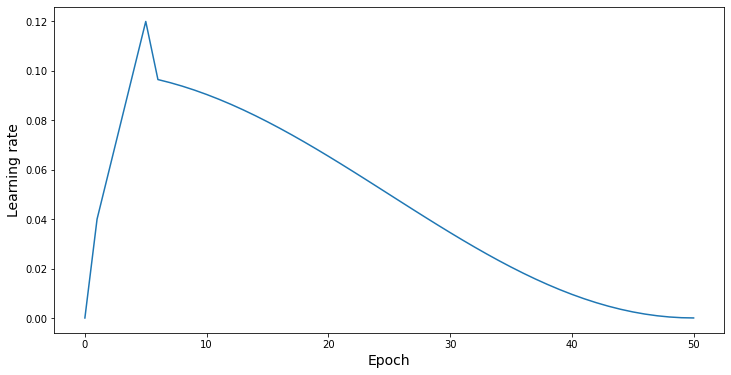

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(lr_list))), lr_list, label="lr")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Learning rate", fontsize=14)
plt.show()

### 3. Tuning siêu tham số

Cài đặt thư viện ray

In [ ]:
!pip install ray

     |████████████████████████████████| 49.6 MB 6.8 kB/s 
     |████████████████████████████████| 72 kB 564 kB/s 


In [ ]:
import os
from ray.tune import CLIReporter
from ray import tune
from torch.utils.data import random_split
from functools import partial

Viết hàm huấn luyện mô hình nơ-ron trên tập CIFAR10

In [ ]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(5):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            print("*"*10, path, "*"*10)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

Lựa chọn siêu tham số tốt (hyperparameter tuning): l1 nhận giá trị 32 hoặc 64, l2 nhận giá trị 32 hoặc 64, lr bằng 1e-4 hoặc 1e-2, batchsize cố định 16

In [ ]:
def main(num_samples=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")

    # Liệt kê các giá trị của các siêu tham số cần tìm kiếm
    ######################
    ### YOUR CODE HERE ###
    ######################
    config = {
        "l1": tune.grid_search([32,64]),
        "l2": tune.grid_search([32,16]),
        "lr": tune.grid_search([1e-4,1e-2]),
        "batch_size": tune.grid_search([16])
    }

    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        progress_reporter=reporter)

main(num_samples=10, gpus_per_trial=1)

/usr/local/lib/python3.7/dist-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)
2021-10-06 08:11:39,937	WARNING experiment.py:296 -- No name detected on trainable. Using DEFAULT.
2021-10-06 08:11:39,940	INFO registry.py:67 -- Detected unknown callable for trainable. Converting to class.
2021-10-06 08:11:39,999	INFO logger.py:597 -- pip install 'ray[tune]' to see TensorBoard files.
2021-10-06 08:11:40,002	WARNING callback.py:117 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Memory usage on this node: 2.1/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 16/80 (15 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+------+------+--------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |     lr |
|---------------------+----------+-------+--------------+------+------+--------|
| DEFAULT_08ad6_00000 | RUNNING  |       |           16 |   32 |   32 | 0.0001 |
| DEFAULT_08ad6_00001 | PENDING  |       |           16 |   64 |   32 | 0.0001 |
| DEFAULT_08ad6_00002 | PENDING  |       |           16 |   32 |   16 | 0.0001 |
| DEFAULT_08ad6_00003 | PENDING  |       |           16 |   64 |   16 | 0.0001 |
| DEFAULT_08ad6_00004 | PENDING  |       |           16 |   32 |   32 | 0.01   |
| DEFAULT_08ad6_00005 | PENDING  |       

(pid=580) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=580)   cpuset_checked))
(pid=580) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=580)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=580) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning: Impl

(pid=580) [1,  2000] loss: 2.303
Result for DEFAULT_08ad6_00000:
  accuracy: 0.1022
  date: 2021-10-06_08-12-14
  done: false
  experiment_id: 12feb8aae69644b19a85d737f8eb1372
  hostname: a2ec0daafcd6
  iterations_since_restore: 1
  loss: 2.302607650375366
  node_ip: 172.28.0.2
  pid: 580
  should_checkpoint: true
  time_since_restore: 33.11549258232117
  time_this_iter_s: 33.11549258232117
  time_total_s: 33.11549258232117
  timestamp: 1633507934
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08ad6_00000
  
== Status ==
Memory usage on this node: 3.1/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 17/80 (16 PENDING, 1 RUNNING)
+---------------------+----------+----------------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name         

(pid=579) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=579)   cpuset_checked))
(pid=579) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=579)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=579) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning: Impl

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 18/80 (16 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00001 | RUNNING    |       |           16 |   64 |   32 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00002 | PENDING    |       |           16 |   32 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00003 | PENDIN

(pid=1505) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1505)   cpuset_checked))
(pid=1505) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1505)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=1505) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 19/80 (16 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00002 | RUNNING    |       |           16 |   32 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00003 | PENDING    |       |           16 |   64 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00004 | PENDIN

(pid=1964) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1964)   cpuset_checked))
(pid=1964) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1964)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=1964) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 20/80 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00003 | RUNNING    |       |           16 |   64 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00004 | PENDING    |       |           16 |   32 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00005 | PENDIN

(pid=2413) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=2413)   cpuset_checked))
(pid=2413) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=2413)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=2413) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 21/80 (16 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00004 | RUNNING    |       |           16 |   32 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00005 | PENDING    |       |           16 |   64 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00006 | PENDIN

(pid=2846) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=2846)   cpuset_checked))
(pid=2846) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=2846)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=2846) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 22/80 (16 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00005 | RUNNING    |       |           16 |   64 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00006 | PENDING    |       |           16 |   32 |   16 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00007 | PENDIN

(pid=3299) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=3299)   cpuset_checked))
(pid=3299) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=3299)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=3299) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 23/80 (16 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00006 | RUNNING    |       |           16 |   32 |   16 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00007 | PENDING    |       |           16 |   64 |   16 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00008 | PENDIN

(pid=3758) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=3758)   cpuset_checked))
(pid=3758) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=3758)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=3758) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

(pid=3758) [1,  2000] loss: 2.295
Result for DEFAULT_08ad6_00007:
  accuracy: 0.2549
  date: 2021-10-06_08-30-03
  done: false
  experiment_id: b2c6fa7518fb4a29a6fa7f8ff8ebb279
  hostname: a2ec0daafcd6
  iterations_since_restore: 1
  loss: 2.1893035694122314
  node_ip: 172.28.0.2
  pid: 3758
  should_checkpoint: true
  time_since_restore: 33.54376530647278
  time_this_iter_s: 33.54376530647278
  time_total_s: 33.54376530647278
  timestamp: 1633509003
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08ad6_00007
  
== Status ==
Memory usage on this node: 3.1/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 24/80 (16 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-----------------+--------------+------+------+--------+---------+------------+----------------------+
|

(pid=4217) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=4217)   cpuset_checked))
(pid=4217) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=4217)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=4217) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 25/80 (16 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00008 | RUNNING    |       |           16 |   32 |   32 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00009 | PENDING    |       |           16 |   64 |   32 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00010 | PENDIN

(pid=4676) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=4676)   cpuset_checked))
(pid=4676) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=4676)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=4676) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 26/80 (16 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00009 | RUNNING    |       |           16 |   64 |   32 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00010 | PENDING    |       |           16 |   32 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00011 | PENDIN

(pid=5133) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=5133)   cpuset_checked))
(pid=5133) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=5133)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=5133) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 27/80 (16 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00010 | RUNNING    |       |           16 |   32 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00011 | PENDING    |       |           16 |   64 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00012 | PENDI

(pid=5592) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=5592)   cpuset_checked))
(pid=5592) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=5592)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=5592) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 28/80 (16 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00011 | RUNNING    |       |           16 |   64 |   16 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00012 | PENDING    |       |           16 |   32 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00013 | PENDI

(pid=6051) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=6051)   cpuset_checked))
(pid=6051) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=6051)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=6051) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 29/80 (16 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00012 | RUNNING    |       |           16 |   32 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00013 | PENDING    |       |           16 |   64 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00014 | PENDI

(pid=6502) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=6502)   cpuset_checked))
(pid=6502) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=6502)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=6502) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 30/80 (16 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00013 | RUNNING    |       |           16 |   64 |   32 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00014 | PENDING    |       |           16 |   32 |   16 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00015 | PENDI

(pid=6955) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=6955)   cpuset_checked))
(pid=6955) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=6955)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=6955) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 31/80 (16 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00014 | RUNNING    |       |           16 |   32 |   16 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00015 | PENDING    |       |           16 |   64 |   16 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00016 | PENDI

(pid=7414) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=7414)   cpuset_checked))
(pid=7414) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=7414)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=7414) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 32/80 (16 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00015 | RUNNING    |       |           16 |   64 |   16 | 0.01   |         |            |                      |
| DEFAULT_08ad6_00016 | PENDING    |       |           16 |   32 |   32 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00017 | PENDI

(pid=7865) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=7865)   cpuset_checked))
(pid=7865) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=7865)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=7865) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:33: UserWarning:

== Status ==
Memory usage on this node: 3.2/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-10-06_08-11-39
Number of trials: 33/80 (16 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+--------+---------+------------+----------------------|
| DEFAULT_08ad6_00016 | RUNNING    |       |           16 |   32 |   32 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00017 | PENDING    |       |           16 |   64 |   32 | 0.0001 |         |            |                      |
| DEFAULT_08ad6_00018 | PENDI

2021-10-06 08:54:29,227	WARNING tune.py:519 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 


KeyboardInterrupt: ignored

Cài đặt thử viện skorch

In [ ]:
!pip install skorch
import numpy as np
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

     |████████████████████████████████| 128 kB 5.3 MB/s 


Sử dụng thư viện skorch để huấn luyện

In [ ]:
trainset, testset = load_data('./data')
(X, y) = np.asarray(trainset.data[:]), np.asarray(trainset.targets[:])
X = X.reshape((-1, 3, 32, 32))
X = X.astype(np.float32)
y = y.astype(np.int64)

net = NeuralNetClassifier(
    Net,
    max_epochs=5,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

# training with default config
net.fit(X, y)
y_proba = net.predict_proba(X)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.1630       0.2396        2.0957  10.9892
      2        2.0223       0.2666        2.0132  10.8343
      3        1.8988       0.3420        1.8394  10.8299
      4        1.8316       0.3364        1.8180  10.8119
      5        1.7825       0.2765        2.0873  10.7259


Dùng skorch để lựa chọn siêu tham số

In [ ]:
# hyperparameter tuning
net.set_params(train_split=False, verbose=0)
# Liệt kê các giá trị siêu tham số cần search và dùng hàm gridsearchCV để tìm giá trị tối ưu

######################
### YOUR CODE HERE ###
######################
prams = {
  "lr" : [1e-4,1e-2],
  "module_l1": [32,64],
  "module_l2": [16,32]
}

gs = GridSearchCV(net,prams,refit = False,  cv=3, scoring='accuracy',verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] lr=0.0001, module_l1=32, module_l2=16 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[CV] ............ lr=0.0001, module_l1=32, module_l2=16, total=  42.5s
[CV] lr=0.0001, module_l1=32, module_l2=16 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.5s remaining:    0.0s


[CV] ............ lr=0.0001, module_l1=32, module_l2=16, total=  41.6s
[CV] lr=0.0001, module_l1=32, module_l2=16 ...........................
[CV] ............ lr=0.0001, module_l1=32, module_l2=16, total=  42.2s
[CV] lr=0.0001, module_l1=32, module_l2=32 ...........................
[CV] ............ lr=0.0001, module_l1=32, module_l2=32, total=  42.1s
[CV] lr=0.0001, module_l1=32, module_l2=32 ...........................
[CV] ............ lr=0.0001, module_l1=32, module_l2=32, total=  41.5s
[CV] lr=0.0001, module_l1=32, module_l2=32 ...........................
[CV] ............ lr=0.0001, module_l1=32, module_l2=32, total=  41.4s
[CV] lr=0.0001, module_l1=64, module_l2=16 ...........................
[CV] ............ lr=0.0001, module_l1=64, module_l2=16, total=  42.1s
[CV] lr=0.0001, module_l1=64, module_l2=16 ...........................
[CV] ............ lr=0.0001, module_l1=64, module_l2=16, total=  42.0s
[CV] lr=0.0001, module_l1=64, module_l2=16 ...........................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 16.5min finished
